In [1]:
import numpy as np
import scipy
import time
import math
from scipy.stats import norm

import mystic
from mystic.solvers import DifferentialEvolutionSolver, diffev2
from mystic.strategy import Best1Bin
from mystic.monitors import Monitor,VerboseMonitor

from copy import deepcopy

from Tomography import *

from NestedForLoop import get_iterator
from pathlib import Path
from scipy.linalg import sqrtm

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import os
import glob

import pandas as pd

from scipy.optimize import least_squares

import fnmatch
from Efficiencies import finding_file, get_channels_eff, set_raw_counts

In [2]:
Pauli=np.asarray([
        [[1,0],
        [0,1]],


        [[0,1],
        [1,0]],


        [[0,-1j],
        [1j,0]],


        [[1,0],
        [0,-1]]])

In [3]:
### Counting files and printing them to make sure we are analysing the correct data ###
n_files=0
working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringHonest"
#working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringMaliciousBPF\BPF202205262200"
os.chdir(working_dir)

filenames = [i for i in glob.glob("Channel*")]
#filenames = [i for i in glob.glob("StateTomography*")]
filenames.sort(key=os.path.getmtime)

for index, filename in enumerate(filenames):
    os.chdir(working_dir+'\\'+filename)
    filenames_aux=[i for i in glob.glob("StateTomography*")]
    for index_second, filenames_aux_second in enumerate(filenames_aux):
        #print(n_files, filename, filenames_aux_second)
        n_files+=1

In [4]:
working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringHonest"
#working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringMaliciousBPF\BPF202205262200"
os.chdir(working_dir)

filenames = [i for i in glob.glob("Channel*")]
#filenames = [i for i in glob.glob("StateTomography*")]
filenames.sort(key=os.path.getmtime)

qubit_number=2

dirinv_after=np.zeros((int(n_files/2),2**qubit_number,2**qubit_number), dtype=complex)
dirinv_before=np.zeros((int(n_files/2),2**qubit_number,2**qubit_number), dtype=complex)

##################### STATE TOMOGRAPHY ##############################

tomo_n_after=tomo_n_before=0

for index, filename in enumerate(filenames):
    os.chdir(working_dir+'\\'+filename)
    filenames_aux=[i for i in glob.glob("StateTomography*")]
    for index_second, filenames_aux_second in enumerate(filenames_aux):
        #print(index, filenames_aux_second)
        os.chdir(working_dir+'\\'+filename+'\\'+filenames_aux_second+'\\'+'StateTomo')
        datafiles=[i for i in glob.glob("*")]
                
        ##Calculating the efficiencies of each detector
        efficiencies=get_channels_eff(datafiles, os.getcwd())
    
        ### Opening the data files and writing the data in counts_aux array
        counts_aux=set_raw_counts(datafiles, qubit_number, os.getcwd())
        xp_counts=np.array(np.transpose(counts_aux))

        statetomo=LRETomography(int(qubit_number), xp_counts, efficiencies, 'C:\\Users\\LauraMartins\\Documents\\PhD\\Lab\\Code\\Tomographies')
        statetomo.run(correct_eff='y', print_nc='n')
        statetomo.quantum_state.get_density_matrix()
        
        ### The 'e' and 'r' serve to distinguish between tomography before and after, respectively
        ### We want to save them in different arrays because we need them for different things
        if filenames_aux_second[-8]=='e':
            dirinv_before[tomo_n_before]=statetomo.quantum_state.get_density_matrix()
            #print('\n Fast maximum likelihood estimation: \n', dirinv_before[tomo_n_before], '\n')
            tomo_n_before+=1
            
        elif filenames_aux_second[-8]=='r':
            dirinv_after[tomo_n_after]=statetomo.quantum_state.get_density_matrix()
            #print('\n Fast maximum likelihood estimation: \n', dirinv_after[tomo_n_after], '\n')
            tomo_n_after+=1
            

In [25]:
### Functions that will be necessary
def fidelity(ideal, real):
    return (ideal@real@np.transpose(np.conjugate(ideal)))

def GeneralUnitary(x):
    return np.array([[np.exp(1j*x[0])*np.cos(x[2]), np.exp(1j*x[1])*np.sin(x[2])],[-np.exp(-1j*x[1])*np.sin(x[2]), np.exp(-1j*x[0])*np.cos(x[2])]])

def ApplyUnitaryToDM(U, dm):
    return U@dm@np.transpose(np.conjugate(U))

#def fUnitary(x, *args):
def fUnitary(x, data_points, bell):
    U1=GeneralUnitary(x[:3])
    U2=GeneralUnitary(x[3:])
    return -np.abs(fidelity(bell, ApplyUnitaryToDM(np.kron(U1,U2), data_points)))

### Jones formalism representation of a waveplate as a funtion of:
### angle of the WP to the horizontal (t) and the phase difference induced between V and H (n)
def WP_rotation(t, n):
    R= np.exp(-1j*n/2)*np.array([[np.cos(t)**2+np.exp(1j*n)*np.sin(t)**2,(1-np.exp(1j*n))*np.cos(t)*np.sin(t)],
                [(1-np.exp(1j*n))*np.cos(t)*np.sin(t),np.sin(t)**2+np.exp(1j*n)*np.cos(t)**2]])
    return(R)

In [12]:
### Fidelity as a projection

#bell=(np.array([1,0,0,0])+np.array([0,0,0,1]))/np.sqrt(2)
#bell=(np.array([1,0,0,0])-np.array([0,0,0,1]))/np.sqrt(2)
bell=(np.array([0,1,0,0])+np.array([0,0,1,0]))/np.sqrt(2)
#bell=(np.array([0,1,0,0])-np.array([0,0,1,0]))/np.sqrt(2)
bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))

for i in range(int(n_files/2-1)):
    print(i, fidelity(bell, dirinv_after[i]))

0 (0.999797351205923+1.3444106938820255e-17j)
1 (0.9996597942800254+0j)
2 (5.980690904882225e-05+0j)
3 (0.9998552769601237-4.336808689942018e-19j)
4 (0.9999462889166644+1.3877787807814457e-17j)
5 (0.9996439167821436-3.686287386450715e-18j)
6 (0.9999223140458655-4.336808689942018e-18j)
7 (0.9997307933426929+0j)
8 (0.9996994920143649+1.3877787807814457e-17j)
9 (0.9995541096051992+0j)
10 (0.999773740234895-1.0842021724855044e-18j)
11 (0.9999223140458655-4.336808689942018e-18j)


In [27]:
### Optimization of a unitary up to isometry
fid=np.zeros((n_files))
Optimized_matrix=np.zeros((n_files,2**qubit_number,2**qubit_number), dtype='complex')
for index in range(int(n_files/2-1)):
    result_w=diffev2(fUnitary, x0=np.array([0, 0, 0, 0, 0, 0]), args=(dirinv_after[index], bell), strategy=Best1Bin, bounds=[(-np.pi,np.pi)]*6, npop=50, gtol=100, disp=True, ftol=1e-20, itermon=VerboseMonitor(50), handler=False)
    print('\n The parameters are: ', index, result_w)

    print('\n with a fidelity of: ', -fUnitary(result_w, dirinv_after[index], bell))

    Unit1=GeneralUnitary(result_w[:3])
    Unit2=GeneralUnitary(result_w[3:])
    print('Unitaries: \n U1=', Unit1, '\n U2=', Unit2)
    Optimized_matrix[index]=ApplyUnitaryToDM(np.kron(Unit1,Unit2), dirinv_after[index])
    print('\n State after unitaries: \n', Optimized_matrix[index])
    fid[index]=fidelity(bell, Optimized_matrix[index])
    print("\n\n Fidelity is: ", index, fidelity(bell, Optimized_matrix[index]))

Generation 0 has ChiSquare: -0.999797
Generation 50 has ChiSquare: -0.999944
Generation 100 has ChiSquare: -0.999944
Generation 150 has ChiSquare: -0.999944
Generation 200 has ChiSquare: -0.999944
Generation 250 has ChiSquare: -0.999944
Generation 300 has ChiSquare: -0.999944
Generation 350 has ChiSquare: -0.999944
Generation 400 has ChiSquare: -0.999944
STOP("ChangeOverGeneration with {'tolerance': 1e-20, 'generations': 100}")
Optimization terminated successfully.
         Current function value: -0.999944
         Iterations: 441
         Function evaluations: 22100

 The parameters are:  0 [ 1.88484802  1.4799729   0.06839815  1.89166536  1.62488215 -0.06930157]

 with a fidelity of:  0.9999436078878694
Unitaries: 
 U1= [[-0.30819237+0.94886588j  0.00619878+0.06806314j]
 [-0.00619878+0.06806314j -0.30819237-0.94886588j]] 
 U2= [[-0.3146343 +0.94668381j  0.00374341-0.06914485j]
 [-0.00374341-0.06914485j -0.3146343 -0.94668381j]]

 State after unitaries: 
 [[ 1.72907244e-05-5.42101086

C:\Users\LAURAM~1\AppData\Local\Temp/ipykernel_12828/1753817189.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  fid[index]=fidelity(bell, Optimized_matrix[index])


Generation 50 has ChiSquare: -0.999958
Generation 100 has ChiSquare: -0.999958
Generation 150 has ChiSquare: -0.999958
Generation 200 has ChiSquare: -0.999958
Generation 250 has ChiSquare: -0.999958
Generation 300 has ChiSquare: -0.999958
STOP("ChangeOverGeneration with {'tolerance': 1e-20, 'generations': 100}")
Optimization terminated successfully.
         Current function value: -0.999958
         Iterations: 339
         Function evaluations: 17000

 The parameters are:  1 [-0.62640024 -0.06790064 -0.05024756 -0.61482591 -0.26295001  0.04092417]

 with a fidelity of:  0.9999582864551464
Unitaries: 
 U1= [[ 0.80912053-0.58549233j -0.05011068+0.00340779j]
 [ 0.05011068+0.00340779j  0.80912053+0.58549233j]] 
 U2= [[ 0.81618993-0.57633336j  0.03950647-0.01063446j]
 [-0.03950647-0.01063446j  0.81618993+0.57633336j]]

 State after unitaries: 
 [[ 1.51601003e-05-1.35525272e-19j -1.16649329e-03-2.50405352e-03j
  -1.15864484e-03-2.48720570e-03j -9.75360468e-06+1.16058859e-05j]
 [-1.16649329

Generation 50 has ChiSquare: -0.999993
Generation 100 has ChiSquare: -0.999993
Generation 150 has ChiSquare: -0.999993
Generation 200 has ChiSquare: -0.999993
Generation 250 has ChiSquare: -0.999993
Generation 300 has ChiSquare: -0.999993
STOP("ChangeOverGeneration with {'tolerance': 1e-20, 'generations': 100}")
Optimization terminated successfully.
         Current function value: -0.999993
         Iterations: 349
         Function evaluations: 17500

 The parameters are:  7 [ 0.09047987 -0.03353777 -0.03329059  0.08154794  0.32061406  0.02422461]

 with a fidelity of:  0.9999927431667817
Unitaries: 
 U1= [[ 0.99535767+0.0903064j  -0.03326573+0.00111608j]
 [ 0.03326573+0.00111608j  0.99535767-0.0903064j ]] 
 U2= [[ 0.99638438+0.08143369j  0.02298792+0.00763362j]
 [-0.02298792+0.00763362j  0.99638438-0.08143369j]]

 State after unitaries: 
 [[4.76298704e-08-4.51045044e-20j 1.53975870e-04+1.52913946e-05j
  1.53153954e-04+1.52097688e-05j 4.67018156e-08+9.36643279e-09j]
 [1.53975870e-04-

In [48]:
### ERROR DUE TO WAVEPLATES UNCERTAINTY ###
## In our xp_counts matrix, every entry corresponds to a different projection basis, which is associated to associated to
## a different set of {HWP,QWP}. We need to simulate new number of counts for each entry, given the angle and the
## the uncertainty of the WP's we are using

HWP_dict={"d": np.pi/8,
          "l": 0,
          "v": 0,
          "a": -np.pi/8,
          "r": 0,
          "h": np.pi/4}

QWP_dict={"d": np.pi/2,
          "l": 3*np.pi/4,
          "v": np.pi/2,
          "a": np.pi/2,
          "r": np.pi/4,
          "h": np.pi/2}

projector_dict={"d": np.array([1,1])/np.sqrt(2),
                "l": np.array([1,1j])/np.sqrt(2),
                "v": np.array([1,0]),
                "a": np.array([1,-1])/np.sqrt(2),
                "r": np.array([1,-1j])/np.sqrt(2),
                "h": np.array([0,1])}


ob=np.transpose(np.array([['dd', 'dl', 'dv', 'ld', 'll', 'lh', 'vd', 'vl', 'vv'],
                       ['da', 'dr', 'dh', 'la', 'lr', 'lh', 'va', 'vr', 'vh'],
                       ['ad', 'al', 'av', 'rd', 'rl', 'rv', 'hd', 'hl', 'hv'],
                       ['aa', 'ar', 'ah', 'ra', 'rr', 'rh', 'ha', 'hr', 'hh']]))

lines, columns = np.shape(ob)

In [49]:
### Uncertainty on the WP
sigma_hwp_arya=0.04*np.pi/180
sigma_qwp_arya=0.1*np.pi/180
sigma_hwp_cersei=0.01*np.pi/180
sigma_qwp_cersei=0.11*np.pi/180

In [50]:
### Defining the number of simulated runs
error_runs=1000
mu=np.zeros((n_files))
std=np.zeros((n_files))

for index in range(n_files):
    xp_counts_err=np.zeros((3**qubit_number,2**qubit_number), dtype=int)
    dm_sim_WP=np.zeros((2**qubit_number,2**qubit_number), dtype=complex)

    dm_sim=np.zeros((error_runs, 2**qubit_number,2**qubit_number), dtype=complex)
    dm_err=np.zeros((error_runs, 2**qubit_number,2**qubit_number), dtype=complex)

    fidelity_sim=np.zeros((error_runs), dtype=float)

    ### For each run we simulate the number of counts we could have within poissionian error and calculate
    ### the correspondent density matrix. With each matrix corresponding to an experimental run, we calculate the fidelity
    ### to the Bell state
    for i in range(error_runs):
        for k in range(lines):
            N_total=np.sum(xp_counts[k])
            for l in range(columns):
                proj=['vv', 'vh', 'hv', 'hh']

                proj_basis=ob[k][0]
                angle_hwp_arya=np.random.normal(loc=HWP_dict[proj_basis[0]], scale=sigma_hwp_arya, size=None)
                angle_qwp_arya=np.random.normal(loc=QWP_dict[proj_basis[0]], scale=sigma_qwp_arya, size=None)
                angle_hwp_cersei=np.random.normal(loc=HWP_dict[proj_basis[1]], scale=sigma_hwp_cersei, size=None)
                angle_qwp_cersei=np.random.normal(loc=QWP_dict[proj_basis[1]], scale=sigma_qwp_cersei, size=None)

                r_arya=WP_rotation(angle_qwp_arya,np.pi/2)@WP_rotation(angle_hwp_arya,np.pi)
                r_cersei=WP_rotation(angle_qwp_cersei,np.pi/2)@WP_rotation(angle_hwp_cersei,np.pi)

                ### Here we need to calculate the probability for a given projector and with that calculate N_total
                ### for the xp_counts matrix and then we apply poissonian noise
                MB_change=np.kron(r_arya,r_cersei)

                dm_sim_WP=MB_change@Optimized_matrix[index]@np.transpose(np.conjugate(MB_change))
                proj_basis_array=np.kron(projector_dict[proj[l][0]],projector_dict[proj[l][1]])

                p=proj_basis_array@dm_sim_WP@np.transpose(np.conjugate(proj_basis_array))

                xp_counts_err[k][l]=np.random.poisson(lam=p*N_total)

        statetomo_err=LRETomography(int(qubit_number), xp_counts_err, "C:\\Users\\LauraMartins\\Documents\\PhD\\Lab\\Code\\Tomographies")
        statetomo_err.run() ### Runs fast maximum likelihood estimation
        statetomo_err.quantum_state.get_density_matrix()
        dm_sim[i]=statetomo_err.quantum_state.get_density_matrix()

        fidelity_sim[i]=fidelity(bell, dm_sim[i])
    mu[index], std[index] = norm.fit(fidelity_sim)
    #print('Fidelity: ', np.round(mu[index],5), '\n Uncertainty: ', np.round(std[index],5))

C:\Users\LAURAM~1\AppData\Local\Temp/ipykernel_22908/467925700.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  xp_counts_err[k][l]=np.random.poisson(lam=p*N_total)
C:\Users\LAURAM~1\AppData\Local\Temp/ipykernel_22908/467925700.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  fidelity_sim[i]=fidelity(bell, dm_sim[i])


In [51]:
import xlsxwriter
working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringHonest"
os.chdir(working_dir)

workbook = xlsxwriter.Workbook('fidelities_errors.xlsx') ### We should write this in another place
 
worksheet = workbook.add_worksheet()

worksheet.write('A1', 'Number')
worksheet.write('B1', 'Folder')
worksheet.write('C1', 'File')
worksheet.write('D1', 'Fidelity')
worksheet.write('E1', 'Uncertainty')
 
# Finally, close the Excel file
# via the close() method.

counter=0
filenames = [i for i in glob.glob("Channel*")]
filenames.sort(key=os.path.getmtime)
for index, filename in enumerate(filenames):
    os.chdir(working_dir+'\\'+filename)
    filenames_aux=[i for i in glob.glob("StateTomography*")]
    for index_second, filenames_aux_second in enumerate(filenames_aux):
        worksheet.write('A'+str(counter+2), counter)
        worksheet.write('B'+str(counter+2),filename)
        worksheet.write('C'+str(counter+2),filenames_aux_second)
        worksheet.write('D'+str(counter+2),np.round(mu[counter],5))
        worksheet.write('E'+str(counter+2),np.round(std[counter],5))
        counter+=1
        
workbook.close()

0.9902684777264444 0.00020653115021695384
52.89906916890987 0.9901366785908849 0.00012899069168909808


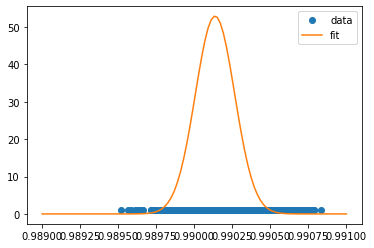

In [52]:
### IF WE WANT TO CHECK THE FIT TO THE UNCERTARTAINTY
### Then we need to calculate the statistic on these simulated fidelities and calculate the standart deviation
### This will be our uncertainty due to statistical errors
def count_elements(seq) -> dict:
    hist = {}
    for i in seq:
        hist[i] = hist.get(i, 0) + 1
    return hist

counted = count_elements(fidelity_sim)
#print(counted)
bin_numb = len(counted)
errorbar_x=np.array(list(counted))
errorbar_y=np.zeros((bin_numb), dtype=int)

for i in range(bin_numb):
    errorbar_y[i]=counted[errorbar_x[i]]
    
#print(errorbar_x)
#print(errorbar_y)
    
def Gauss(x, A, mu, sigm):
    y = A*np.exp(-((x-mu)/sigm)**2/2)
    return y

mu, std = norm.fit(fidelity_sim)
print(mu, std)
parameters, covariance = curve_fit(Gauss, xdata=errorbar_x[-1], ydata=errorbar_y[:-1], bounds=[(50,0.99007,1e-4),(60,0.9903,0.0002)])
fit_A = parameters[0]
fit_B = parameters[1]
fit_C = parameters[2]
print(fit_A, fit_B, fit_C)

xdata= x = np.linspace(0.989, 0.991, 100)
fit_y = Gauss(xdata, fit_A, fit_B, fit_C)
plt.plot(errorbar_x[:-1], errorbar_y[:-1], 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()